#### Introdcution
The Brain-Derived Neurotrophic Factor (BDNF) is a protein that plays a crucial role in the growth, development, and maintenance of neurons in the brain. In recent years, research has focused on identifying ways to increase BDNF levels to promote brain health and treat neurological disorders. In this context, a pilot study was conducted on four subjects to investigate the effectiveness of an intervention in improving BDNF levels. The study observed varying degrees of success, and the findings suggest the need for further research in this area.

In [2]:
"""
Created on Tuesday 8 Nov 2022
Author: ZMW
"""
#import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statistics
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import numpy.random as npr
from scipy.optimize import leastsq
import warnings
warnings.filterwarnings('ignore')

In [4]:
#data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/bdnf_1Aug2023.xlsx' # read raw data
data_path = os.path.join(dirname,data_file)

In [7]:
#Load the fitted dataset
data = pd.read_excel(data_path)
data = data.iloc[9:17,1:5]#slice rows and columns where data exist
#data = data.loc[:,~data.columns.str.contains('Unnamed')]
data.columns = ['STD_1','Sample','Sample','STD_2']
data = data.reset_index(drop=True)


#### Plate layout

|  Standard | Sample | Sample | Standard |
|---|---|---|---|
|  SD1 | S1B | S3B | SD1  |  
|  SD2 |  S1B | S3B | SD2  | 
|  SD3 | S1P |  S3P | SD3  | 
|  SD4 |  S1P|  S3P |  SD4 | 
|  SD5 |  S2B |   S4B|   SD5|  
|  SD6 |   S2B|  S4B|  SD6 |  
|  SD7 |  S2P|  S4P | SD7 | 
|  blank |  S2P|   S4P| blank | 

### Raw

In [9]:
data

,STD_1,Sample,Sample,STD_2
0,2.8924,1.9646,2.86685,2.625
1,2.2235,1.6891,2.6443,1.966
2,1.3228,1.8976,2.6443,1.966
3,0.6515,1.7714,2.2898,0.5458
4,0.3314,2.4695,3.1526,0.2816
5,0.2322,2.2032,2.9162,0.1798
6,0.1511,2.7705,2.5525,0.1197
7,0.1041,2.6266,2.4415,0.0879


### Average concentration

In [10]:
# Standard
STD1 = statistics.mean([data.iloc[0,0],data.iloc[0,3]])
STD2 = statistics.mean([data.iloc[1,0],data.iloc[1,3]])
STD3 = statistics.mean([data.iloc[2,0],data.iloc[2,3]])
STD4 = statistics.mean([data.iloc[3,0],data.iloc[3,3]])
STD5 = statistics.mean([data.iloc[4,0],data.iloc[4,3]])
STD6= statistics.mean([data.iloc[5,0],data.iloc[5,3]])
STD7 = statistics.mean([data.iloc[6,0],data.iloc[6,3]])
STD8 = statistics.mean([data.iloc[7,0],data.iloc[7,3]])

# Unknown samples
S1_5 = statistics.mean([data.iloc[0,1],data.iloc[1,1]])
S2_5 = statistics.mean([data.iloc[2,1],data.iloc[3,1]])
S3_5 = statistics.mean([data.iloc[4,1],data.iloc[5,1]])
S4_5 = statistics.mean([data.iloc[6,1],data.iloc[7,1]])

S1_10 = statistics.mean([data.iloc[0,2],data.iloc[1,2]])
S2_10 = statistics.mean([data.iloc[2,2],data.iloc[3,2]])
S3_10 = statistics.mean([data.iloc[4,2],data.iloc[5,2]])
S4_10 = statistics.mean([data.iloc[6,2],data.iloc[7,2]])

### Blank correction

In [11]:
# Standard
STD1 = STD1-STD8
STD2 = STD2-STD8
STD3 = STD3-STD8
STD4 = STD4-STD8
STD5 = STD5-STD8
STD6 = STD6-STD8
STD7 = STD7-STD8

# Unknown samples
# Unknown samples
S1_5 = S1_5 - STD8
S2_5 = S2_5 - STD8
S3_5 = S3_5 - STD8
S4_5 = S4_5 - STD8

S1_10 = S1_10 - STD8
S2_10 = S2_10 - STD8
S3_10 = S3_10 - STD8
S4_10 = S4_10 - STD8

In [34]:
# Sample dataframe
col = {'Subject':['S1B','S1P','S2B','S2P','S3B','S3P','S4B','S4P'],'Unknown_Samples':[S1_5,S2_5,S3_5,S4_5,S1_10,S2_10,S3_10,S4_10],'Standard':[STD1,STD2,STD3,STD4,STD5,STD6,STD7,STD8]}
data = pd.DataFrame.from_dict(col)

In [36]:
data

,Subject,Unknown_Samples,Standard
0,S1B,1.730850,2.66270
1,S1P,1.738500,1.99875
2,S2B,2.240350,1.54840
3,S2P,2.602550,0.50265
4,S3B,2.659575,0.21050
5,S3P,2.371050,0.11000
6,S4B,2.938400,0.03940
7,S4P,2.401000,0.09600


# 4PL curve fit for standard

In [37]:
concen_ng_ml =  [16, 6.4, 2.56, 1.024, 0.41, 0.164,0.066]
std = {'concentrations(ng/ml)':concen_ng_ml,'STD_OD':data['Standard'][:-1]}
df_std = pd.DataFrame(std)
df_std

,concentrations(ng/ml),STD_OD
0,16.000,2.66270
1,6.400,1.99875
2,2.560,1.54840
3,1.024,0.50265
4,0.410,0.21050
5,0.164,0.11000
6,0.066,0.03940


### 4PL curve fitting

We want to fit a 4 parameter logistic (4PL) equation to ELISA data. The equation for the 4PL model is

<img src="4pl.png" alt="drawing" width="200"/>

where \(y\) is the reponse(i.e absorbance), \(x\) is the concentration of analyte, \(a\) is the minimum asymptote, \(b\) is the steepness, \(c\) is the inflection point and \(d\) is the maximum asymptote.

In [38]:
# define function for y
def logistic_4(x, A, B, C, D):
    """ 4PL logistic equation"""
    return ((A - D) / (1.0 + ((x / C) ** B))) + D

In [39]:
# define function for x for unknow concentration
def fourpl(y, A, B, C, D):
    """ 4PL logistic equation"""
    return C * ((A-D)/(y-D)-1)**(1/B)

In [40]:
# initial guesses
InitialGuess = [np.min(df_std['STD_OD']), 1, np.median(concen_ng_ml), np.max(df_std['STD_OD'])]

In [41]:
# # initial guesses
# InitialGuess = [0, 2, np.mean(concen_ng_ml), 1]

In [42]:
# initial guesses
InitialGuess = [0.0846, 1.13705, 1.89435, 2.72295]

In [43]:
x = df_std['concentrations(ng/ml)'].values.flatten()
y = df_std['STD_OD'].values.flatten()

In [44]:
#curve fit data into model
ET_popt, ET_pcov = curve_fit(logistic_4, x, y, p0=InitialGuess)
ET_perr = np.sqrt(np.diag(ET_pcov))

y_pred = logistic_4(x, *ET_popt)

R_sq_ET = r2_score(y_pred, y)

#print(ET_popt) # print fitted parameters
print("ET fit R^2: ", R_sq_ET)

ET fit R^2:  0.9885570917863247


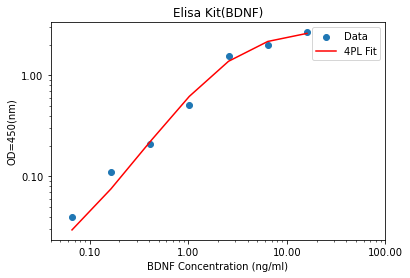

In [45]:
fig, ax = plt.subplots()
#ax.plot(x,y)

# Set the x-axis scale to 0.01, 0.1, 1, 10, and 100
ax.set_xscale('log')
ax.set_xticks([0.01, 0.1, 1, 10, 100])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim([0.04, 100])


# Set the y-axis scale to 0.01, 0.1, 1, and 10
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 1, 10])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
#ax.set_ylim([0.05, 10])

plt.scatter(x,y,label='Data')
plt.plot(x, logistic_4(x, *ET_popt), 'r', label="4PL Fit")
plt.title('Elisa Kit(BDNF)')
plt.xlabel('BDNF Concentration (ng/ml)')
plt.ylabel('OD=450(nm)')
plt.legend()
plt.show()

In [46]:
# Print the parameter values and R-squared value
A = ET_popt[0]
B = ET_popt[1]
C = ET_popt[2]
D = ET_popt[3]


print('A =', ET_popt[0])
print('B =', ET_popt[1])
print('C =', ET_popt[2])
print('D =', ET_popt[3])
print('R-squared =', R_sq_ET)

A = 0.009950376048736045
B = 1.3382406222680037
C = 2.6859266326510993
D = 2.8310898223254206
R-squared = 0.9885570917863247


### Fit unknown sample OD values to the 4-parameter logistic (4PL) curve

In [47]:
data

,Subject,Unknown_Samples,Standard
0,S1B,1.730850,2.66270
1,S1P,1.738500,1.99875
2,S2B,2.240350,1.54840
3,S2P,2.602550,0.50265
4,S3B,2.659575,0.21050
5,S3P,2.371050,0.11000
6,S4B,2.938400,0.03940
7,S4P,2.401000,0.09600


In [48]:
logistic_4(data.iloc[0,1],A, B, C, D)*5

5.086678706554199

In [49]:
logistic_4(data.iloc[5,1],A, B, C, D)

1.303102192508905

In [50]:
comp_values= {'Sample':data['Subject'],
    'conc(ng/ml)':[fourpl(data.iloc[0,1],A, B, C, D)*5,fourpl(data.iloc[1,1],A, B, C, D)*5,
                   fourpl(data.iloc[2,1],A, B, C, D)*5,fourpl(data.iloc[3,1],A, B, C, D)*5,
                   fourpl(data.iloc[4,1],A, B, C, D)*10,fourpl(data.iloc[5,1],A, B, C, D)*5,
                   fourpl(data.iloc[6,1],A, B, C, D)*10,fourpl(data.iloc[7,1],A, B, C, D)*5],
                   'Dilutions':['5 fold','5 fold','5 fold','5 fold','5 fold','5 fold','5 fold','5 fold']}
df_unsamp = pd.DataFrame(comp_values)
df_unsamp


,Sample,conc(ng/ml),Dilutions
0,S1B,18.759921,5 fold
1,S1P,18.920594,5 fold
2,S2B,36.242415,5 fold
3,S2P,82.460024,5 fold
4,S3B,207.723900,5 fold
5,S3P,45.587920,5 fold
6,S4B,NaN,5 fold
7,S4P,48.393521,5 fold


### Conclusion
Based on the results of our pilot study on four subjects, it appears that the intervention had a success rate of 50 percent in improving BDNF levels. Specifically, while BDNF levels improved in two of the subjects, the other two did not show significant improvement. These findings suggest that the intervention may be effective for some individuals, but further research is needed to confirm these observations.